In [1]:

import sys
import numpy as np
import torch
import mlflow
from pathlib import Path
import time
import json
from datetime import datetime
from typing import Dict, Any
import yaml
from abc import ABC, abstractmethod
import inspect

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

from src.models.base.base_model import ParametricModel, DeepLearningModel
from src.models.parametric.gbm import GeometricBrownianMotion
from src.models.parametric.ou_process import OrnsteinUhlenbeckProcess
from src.models.parametric.merton_jump_diffusion import MertonJumpDiffusion
from src.models.parametric.garch11 import GARCH11
from src.models.parametric.de_jump_diffusion import DoubleExponentialJumpDiffusion
from src.models.parametric.block_bootstrap import BlockBootstrap
from src.models.non_parametric.time_gan import TimeGAN

from src.utils.display_utils import show_with_start_divider, show_with_end_divider
from src.utils.preprocessing_utils import create_dataloaders, preprocess_data
from src.utils.configs_utils import get_dataset_cfgs, get_model_cfgs
from src.utils.evaluation_classes_utils import (
    TaxonomyEvaluator,
    DiversityEvaluator,
    FidelityEvaluator,
    RuntimeEvaluator,
    StylizedFactsEvaluator,
    VisualAssessmentEvaluator
)

In [2]:
class UnifiedEvaluator:
    """
    Unified evaluator class to initialize the MLFlow experiment and evaluate the models.
    """
    
    def __init__(
        self, 
        experiment_name: str,
        model_cfgs: Dict[str, Any],
        nonparametric_dataset_cfgs: Dict[str, Any],
        parametric_dataset_cfgs: Dict[str, Any]
    ):
        """
        Initialize the evaluator with MLFlow experiment.
        
        Args:
            experiment_name (str): Name of the MLFlow experiment
            model_cfgs (Dict[str, Any]): Configuration for models
            nonparametric_dataset_cfgs (Dict[str, Any]): Configuration for non-parametric dataset
            parametric_dataset_cfgs (Dict[str, Any]): Configuration for parametric dataset
        """
        self.model_cfgs = model_cfgs
        self.nonparametric_dataset_cfgs = nonparametric_dataset_cfgs
        self.parametric_dataset_cfgs = parametric_dataset_cfgs

        self.experiment_name = experiment_name
        mlflow.set_experiment(experiment_name)
        
        self.results = {}
        self.results_dir = project_root / "results"
        self.results_dir.mkdir(exist_ok=True)
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    def evaluate_model(
        self,
        model,
        model_name: str,
        real_data: np.ndarray,
        train_data,
        num_samples: int = 500,
        generation_kwargs: Dict[str, Any] = None
    ) -> None:
        """
        Unified evaluation for both parametric and non-parametric models.

        Args:
            model: The type of generative model to evaluate
            model_name: Name of the model for logging
            real_data: Real data for comparison
            train_data: Training data
            generation_kwargs: Optional kwargs for model.generate() (e.g., linear_timestamps, output_length)

        Returns:
            Dictionary containing all evaluation metrics
        """
        show_with_start_divider(f"Evaluating {model_name}")
        generation_kwargs = generation_kwargs or {}

        with mlflow.start_run(run_name=f"{model_name}_{self.timestamp}"):
            mlflow.log_param("model_name", model_name)
            mlflow.log_param(
                "model_type",
                "parametric" if isinstance(model, ParametricModel) else "non_parametric"
            )

            evaluation_results: Dict[str, Any] = {}

            print(f"Training {model_name}...")
            model.fit(train_data)
            print(f"Training {model_name} completed!")

            print(f"\nGenerating {num_samples} samples...")
            runtime_evaluator = RuntimeEvaluator(
                generate_func=lambda n, **kwargs: model.generate(n, **generation_kwargs),
                num_samples=num_samples,
                generation_kwargs=generation_kwargs
            )
            runtime_results = runtime_evaluator.evaluate()
            mlflow.log_metric(
                f"generation_time_{num_samples}_samples",
                runtime_results[f"generation_time_{num_samples}_samples"]
            )
            evaluation_results.update(runtime_results)

            generated_data = model.generate(num_samples, **generation_kwargs)

            if "torch" in str(type(generated_data)):
                generated_data = generated_data.detach().cpu().numpy()
            if "torch" in str(type(real_data)):
                real_data = real_data.detach().cpu().numpy()
            else:
                real_data = np.asarray(real_data)

            if real_data.ndim == 2:
                l, N = real_data.shape
                B = generated_data.shape[1]
                if l >= B:
                    num_windows = l - B + 1
                    real_data_3d = np.lib.stride_tricks.sliding_window_view(real_data, (B, N), axis=(0, 1))
                    real_data_3d = real_data_3d.squeeze()
                    A_real = min(num_windows, num_samples)
                    real_data = real_data_3d[:A_real]
                else:
                    real_data = real_data[np.newaxis, :, :]

            print(f"Generated data shape: {generated_data.shape}")
            print(f"Real data shape: {real_data.shape}")

            evaluators = [
                FidelityEvaluator(real_data, generated_data),
                DiversityEvaluator(real_data, generated_data),
                StylizedFactsEvaluator(real_data, generated_data),
                VisualAssessmentEvaluator(real_data, generated_data, self.results_dir, self.timestamp)
            ]

            for evaluator in evaluators:
                print(f"Computing {evaluator.__class__.__name__}...")
                results = evaluator.evaluate(model_name) if isinstance(evaluator, VisualAssessmentEvaluator) else evaluator.evaluate()
                
                if results:
                    evaluation_results.update(results)
                    for metric_name, metric_score in results.items():
                        if isinstance(metric_score, (int, float)):
                            mlflow.log_metric(metric_name, metric_score)
                            continue

                        if isinstance(metric_score, (np.ndarray, list)):
                            channel_scores = np.array(metric_score)
                            mlflow.log_metric(f"{metric_name}_mean", float(np.mean(channel_scores)))
                            mlflow.log_metric(f"{metric_name}_std", float(np.std(channel_scores)))

            self.results[model_name] = evaluation_results

            results_path = self.results_dir / f"metrics_{model_name}_{self.timestamp}.json"
            with open(results_path, 'w') as f:
                json.dump(evaluation_results, f, indent=2, default=str)
            mlflow.log_artifact(str(results_path))

            print(f"Evaluation completed for {model_name}!")

    
    def run_complete_evaluation(self, num_samples: int = 500) -> Dict[str, Any]:
        """
        Run complete evaluation on all models with 500 generated samples per model.
        
        Args:
            dataset_config: Configuration for data preprocessing
            models_config: Configuration for models
            
        Returns:
            Dictionary containing results for all models
        """
        show_with_start_divider("Starting Complete Evaluation Pipeline")
        
        print("  Preprocessing data for non-parametric models...")
        train_data_np, valid_data_np = preprocess_data(self.nonparametric_dataset_cfgs)
        train_data_para, valid_data_para = preprocess_data(self.parametric_dataset_cfgs)
        
        batch_size = 32
        train_loader, valid_loader = create_dataloaders(
            train_data_np, valid_data_np,
            batch_size=batch_size,
            train_seed=42,
            valid_seed=123,
            num_workers=0,
            pin_memory=False
        )
        
        num_samples_real, length, num_channels = train_data_np.shape
        print(f"  - Non-parametric data shape: {train_data_np.shape}")
        print(f"  - Parametric data shape: {train_data_para.shape}")
        
        models = {}
        
        models["GBM"] = GeometricBrownianMotion(length=length, num_channels=num_channels)
        models["OU_Process"] = OrnsteinUhlenbeckProcess(length=length, num_channels=num_channels)
        models["Merton_Jump_Diffusion"] = MertonJumpDiffusion(length=length, num_channels=num_channels)
        models["GARCH11"] = GARCH11(length=length, num_channels=num_channels)
        models["Double_Exponential_Jump_Diffusion"] = DoubleExponentialJumpDiffusion(length=length, num_channels=num_channels)
        # models["BlockBootstrap"] = BlockBootstrap(length=length, num_channels=num_channels, block_size=125)

        models["TimeGAN"] = TimeGAN(
            seq_length=length,
            num_features=num_channels,
            embedding_dim=self.model_cfgs.get("latent_dim", 64),
            hidden_dim=self.model_cfgs.get("hidden_dim", 128),
            num_layers=self.model_cfgs.get("num_layers", 1),
            batch_size=self.model_cfgs.get("batch_size", 16),
            learning_rate=self.model_cfgs.get("learning_rate", 0.0002)
        )
        
        
        all_results = {}
        for model_name, model in models.items():
            try:
                is_parametric = isinstance(model, ParametricModel)
                
                results = self.evaluate_model(
                    model=model,
                    model_name=model_name,
                    real_data=valid_data_para if is_parametric else valid_data_np,
                    train_data=train_data_para if is_parametric else train_loader,
                    num_samples=num_samples,
                    generation_kwargs={'output_length': length, 'seed': 42} if is_parametric else {}
                )
                all_results[model_name] = results
            except Exception as e:
                print(f"Error evaluating {model_name}: {e}")
                import traceback
                traceback.print_exc()
                all_results[model_name] = {"error": str(e)}
        
        results_file = self.results_dir / f"complete_evaluation_{self.timestamp}.json"
        with open(results_file, 'w') as f:
            json.dump(self.results, f, indent=2, default=str)
        mlflow.log_artifact(str(results_file))
        
        show_with_end_divider("EVALUATION COMPLETE")
        print(f"Results saved to: {results_file}")
        print(f"MLFlow experiment: {self.experiment_name}")
        
        return all_results

def main():
    """Main function to run the evaluation pipeline."""
    nonparametric_dataset_cfgs, parametric_dataset_cfgs = get_dataset_cfgs()
    model_cfgs = get_model_cfgs()
    
    evaluator = UnifiedEvaluator(
        experiment_name="TimeSeries_Generation_Comprehensive_Evaluation",
        model_cfgs = model_cfgs,
        nonparametric_dataset_cfgs = nonparametric_dataset_cfgs,
        parametric_dataset_cfgs = parametric_dataset_cfgs
    )
    evaluator.run_complete_evaluation(num_samples=500)

Starting Complete Evaluation Pipeline
  Preprocessing data for non-parametric models...
Data preprocessing with settings:{'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.2, 'do_normalization': True, 'seed': 42}
Data shape: (1131, 125, 4)
Preprocessing for non-parametric models done.

Data preprocessing with settings:{'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'is_parametric': True, 'seed': 42}
Data shape: (1255, 4)
Preprocessing for parametric models done.

  - Non-parametric data shape: (904, 125, 4)
  - Parametric data shape: torch.Size([1129, 4])
Evaluating GBM
Training GBM...
Training GBM completed!

Generating 500 samples...
Generated data shape: (500, 125, 4)
Real data shape: (2, 125, 4)
Computing FidelityEvaluator...
Computing DiversityEvaluator...
Computing StylizedFactsEvaluator...
Computing VisualAssessmentEvaluator...
Eva

C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main\src\taxonomies\stylized_facts.py:37: RuntimeWarning: invalid value encountered in log
  data_ret[:, 1:, ch] = np.log(data[:, 1:, ch] + 1e-12) - np.log(data[:, :-1, ch] + 1e-12)


Computing VisualAssessmentEvaluator...
Evaluation completed for TimeGAN!
EVALUATION COMPLETE

Results saved to: C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main\results\complete_evaluation_20251018_002956.json
MLFlow experiment: TimeSeries_Generation_Comprehensive_Evaluation


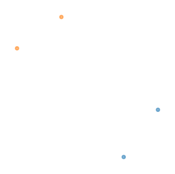

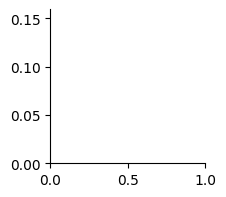

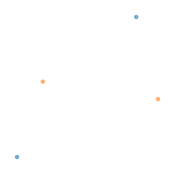

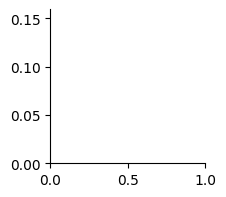

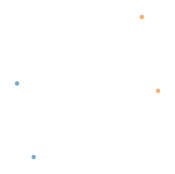

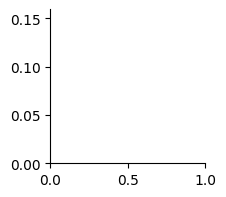

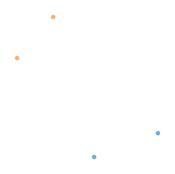

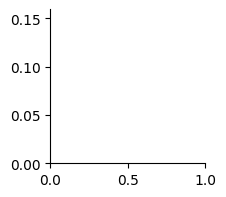

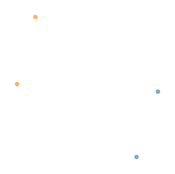

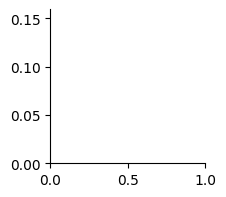

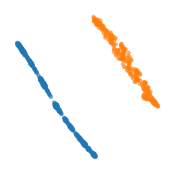

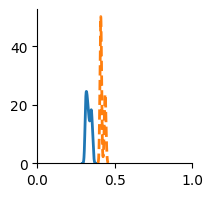

In [3]:
if __name__ == "__main__":
    main()